### Import all required libraries

In [7]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
from skimage import io, color
from skimage.transform import resize
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.utils import class_weight
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficientnet


### Explore dataset garbage_classification_12_classes

In [ ]:
dataset_path = os.path.join(os.pardir, 'data', 'raw_images', 'garbage_classification_12_classes')
EXCLUDED_CLASSES = ['clothes', 'shoes', 'battery'] # Excluding clothes, shoes and battery

In [2]:
# Define the new class mapping
CLASS_MAPPING = {
    'biological': 'trash',
    'brown-glass': 'glass',
    'cardboard': 'cardboard',
    'green-glass': 'glass',
    'metal': 'metal',
    'paper': 'paper',
    'plastic': 'plastic',
    'trash': 'trash',
    'white-glass': 'glass'
}

# Define the original classes we are interested in mapping
relevant_original_classes = ['biological', 'brown-glass', 'cardboard', 'green-glass', 'metal', 'paper', 'plastic', 'trash', 'white-glass']

# Filter out any excluded classes from the relevant original classes
original_classes_to_map = [c for c in relevant_original_classes if c not in EXCLUDED_CLASSES]

# Create the list of our 6 target classes
classes = sorted(list(set(CLASS_MAPPING.values())))
print("Waste types (6 classes):", classes)

Waste types (6 classes): ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [6]:
data = []
for target_class in classes:
    count = 0
    for original_class in original_classes_to_map:
        if CLASS_MAPPING.get(original_class) == target_class:
            class_path = os.path.join(dataset_path, original_class)
            if os.path.exists(class_path) and os.path.isdir(class_path):
                num_images = len(os.listdir(class_path))
                count += num_images
    data.append({"Class": target_class, "Number of images": count})

df_counts = pd.DataFrame(data)
print(df_counts)

       Class  Number of images
0  cardboard               891
1      glass              2011
2      metal               769
3      paper              1050
4    plastic               865
5      trash              1682


### Create Dataframe

In [5]:
metadata = []

# Look for images and classes
for original_class_name in original_classes_to_map:
    original_class_path = os.path.join(dataset_path, original_class_name)
    for img_name in os.listdir(original_class_path):
        img_path = os.path.join(original_class_path, img_name)
        with Image.open(img_path) as img:
            mapped_class = CLASS_MAPPING[original_class_name]
            metadata.append({
                "image_path": img_path,
                "class": mapped_class,
                "width": img.width,
                "height": img.height,
                "channels": len(img.getbands()),
                "aspect_ratio": round(img.width / img.height, 2)
            })

df_metadata = pd.DataFrame(metadata)
df_metadata.head()

,image_path,class,width,height,channels,aspect_ratio
0,C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...,trash,236,214,3,1.10
1,C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...,trash,337,150,3,2.25
2,C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...,trash,263,192,3,1.37
3,C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...,trash,275,183,3,1.50
4,C:\Users\ruben\OneDrive\Escritorio\IRONHACK\fi...,trash,277,182,3,1.52


### Image resizing

In [ ]:
images = []
labels = []

IMG_SIZE = (224, 224)

class_to_index = {class_name: i for i, class_name in enumerate(classes)}
print("Class to index mapping (6 classes):", class_to_index)

for index, row in df_metadata.iterrows():
    img_path = row['image_path']
    class_name = row['class']

    with Image.open(img_path) as img:
        img = img.convert('RGB')
        img_array = np.array(img).astype(np.float32) 
        img_resized = resize(img_array, IMG_SIZE, anti_aliasing=True)
        img_resized_scaled = img_resized * 255.0
        img_resized_float32 = img_resized_scaled.astype(np.float32)
        images.append(img_resized_float32)
        labels.append(class_to_index[class_name])

images = np.array(images)
labels = np.array(labels)

print("Total number of images uploaded:", len(images))
print("Total number of labels loaded:", len(labels))
print("Image format:", images[0].shape)
print("Label format:", labels.shape)
print("Example of label (class index):", labels[0])
print("Class corresponding to index 0:", classes[0])

Class to index mapping (6 classes): {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
Total number of images uploaded: 7268
Total number of labels loaded: 7268
Image format: (224, 224, 3)
Label format: (7268,)
Example of label (class index): 5
Class corresponding to index 0: cardboard


### Dividing dataset into training, validation and test

In [ ]:
X_train_original, X_temp, y_train_original, y_temp = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

num_classes = len(classes)
y_train_encoded = to_categorical(y_train_original, num_classes=num_classes)
y_val_encoded = to_categorical(y_val, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

print("Training set size:", X_train_original.shape)
print("Size of training labels:", y_train_encoded.shape)
print("Validation set size:", X_val.shape)
print("Size of validation tags:", y_val_encoded.shape)
print("Test set size:", X_test.shape)
print("Size of test labels:", y_test_encoded.shape)

Training set size: (5814, 224, 224, 3)
Size of training labels: (5814, 6)
Validation set size: (727, 224, 224, 3)
Size of validation tags: (727, 6)
Test set size: (727, 224, 224, 3)
Size of test labels: (727, 6)


In [ ]:
# Calculate class weights

current_weights = class_weight.compute_class_weight('balanced', 
                                  classes=np.unique(y_train_original), 
                                  y=y_train_original)
manual_adjustments = [1.0, 0.8, 1.5, 0.7, 2.0, 1.8]  
adjusted_weights = current_weights * manual_adjustments
class_weight_dict = dict(zip(np.unique(y_train_original), adjusted_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: 1.359046283309958, 1: 0.4817899316345557, 2: 2.3634146341463413, 3: 0.8074999999999999, 4: 2.800578034682081, 5: 1.2968029739776952}


### ImageDataGenerator & training EfficientNetB0 model

In [ ]:
# ImageDataGenerator for training with augmentation and preprocessing
train_datagen_adjusted = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_efficientnet
)

train_generator = train_datagen_adjusted.flow(
    X_train_original,
    y_train_encoded,
    batch_size=32,
    shuffle=True,
    seed=42
)

# ImageDataGenerator for validation (only preprocessing)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_efficientnet)
validation_generator = val_datagen.flow(
    X_val,
    y_val_encoded,
    batch_size=32,
    shuffle=False,
    seed=42
)

# Apply ResNet50-specific preprocessing to the test set
X_test_preprocessed = preprocess_efficientnet(X_test)

# Load the pre-trained EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze base model layers to prevent training (initially)
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
predictions = Dense(len(classes), activation='softmax')(x)

# Build the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Show model architecture
model.summary()

# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)


# ModelCheckpoint for saving the best model based on validation loss
checkpoint_filepath = 'best_model_efficientnetb0.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

callbacks = [early_stopping, lr_scheduler]

# Training the model with generators and class weights
epochs = 50
batch_size = 32

history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train_original) // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(X_val) // batch_size,
    callbacks=callbacks,
    class_weight=class_weight_dict # Pass the class weights here
)

# Evaluate the model on the preprocessed test set
loss, accuracy = model.evaluate(X_test_preprocessed, y_test_encoded, verbose=0)
print(f"Loss in the test (with class weights): {loss:.4f}")
print(f"Accuracy in the test (with class weights): {accuracy:.4f}")

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 224, 224, 3)  7          ['rescaling_4[0][0]']            
 )                                                                                                
                                                                                            

### Evaluating model

In [18]:
# Evaluate the model on the test

loss, accuracy = model.evaluate(X_test_preprocessed, y_test_encoded, verbose=0)
print(f"Loss in the test: {loss:.4f}")
print(f"Accuracy in the test: {accuracy:.4f}")

Loss in the test: 2.3045
Accuracy in the test: 0.2187


In [19]:
# Important to run ONLY 1 time
X_train_preprocessed = preprocess_input(X_train_original)
X_val_preprocessed = preprocess_input(X_val)
X_test_preprocessed = preprocess_input(X_test)

In [21]:
# Make predictions on the test set
y_pred_probs = model.predict(X_test_preprocessed)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to labels

y_true = np.argmax(y_test_encoded, axis=1)

report = classification_report(y_true, y_pred, target_names=classes)
print("Classification Report:\n", report)

23/23 [==============================] - 10s 371ms/step
Classification Report:
               precision    recall  f1-score   support

   cardboard       0.11      0.06      0.07        89
       glass       0.58      0.03      0.07       201
       metal       0.14      0.19      0.17        77
       paper       0.00      0.00      0.00       105
     plastic       0.15      0.36      0.21        87
       trash       0.25      0.53      0.34       168

    accuracy                           0.20       727
   macro avg       0.21      0.20      0.14       727
weighted avg       0.27      0.20      0.15       727



In [22]:
y_train_pred_probs = model.predict(X_train_preprocessed)
y_train_pred = np.argmax(y_train_pred_probs, axis=1)
y_train_true = np.argmax(y_train_encoded, axis=1)
report_train = classification_report(y_train_true, y_train_pred, target_names=classes)
print("Classification Report (Training Set):\n", report_train)

182/182 [==============================] - 66s 363ms/step
Classification Report (Training Set):
               precision    recall  f1-score   support

   cardboard       0.10      0.04      0.06       713
       glass       0.30      0.02      0.04      1609
       metal       0.14      0.16      0.15       615
       paper       0.13      0.01      0.03       840
     plastic       0.16      0.39      0.22       692
       trash       0.25      0.53      0.34      1345

    accuracy                           0.20      5814
   macro avg       0.18      0.19      0.14      5814
weighted avg       0.20      0.20      0.14      5814



In [23]:
y_val_pred_probs = model.predict(X_val_preprocessed)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)
y_val_true = np.argmax(y_val_encoded, axis=1)
report_val = classification_report(y_val_true, y_val_pred, target_names=classes)
print("Classification Report (Validation Set):\n", report_val)

23/23 [==============================] - 8s 352ms/step
Classification Report (Validation Set):
               precision    recall  f1-score   support

   cardboard       0.07      0.03      0.05        89
       glass       0.35      0.03      0.06       201
       metal       0.10      0.12      0.11        77
       paper       0.20      0.02      0.03       105
     plastic       0.16      0.40      0.23        86
       trash       0.28      0.58      0.37       169

    accuracy                           0.21       727
   macro avg       0.19      0.20      0.14       727
weighted avg       0.23      0.21      0.15       727



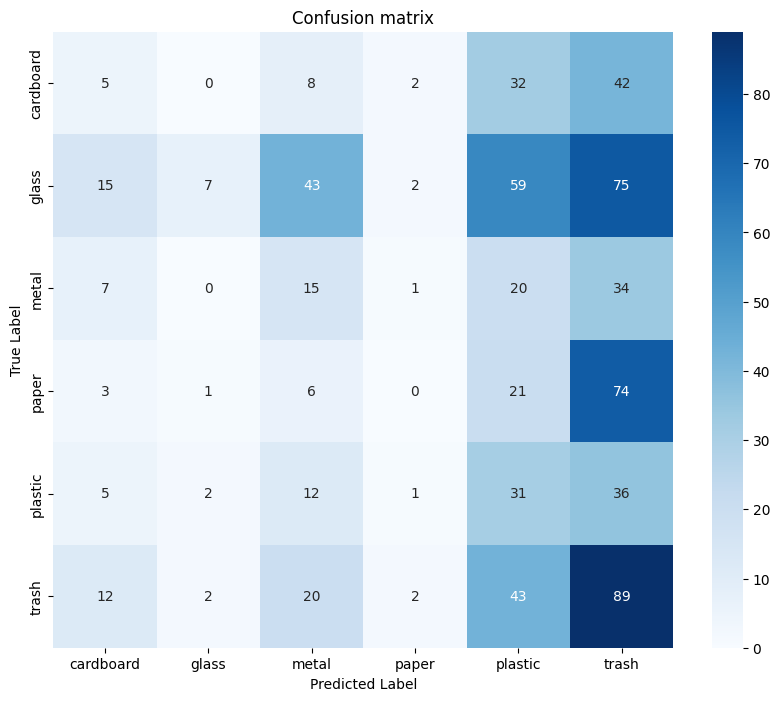

In [24]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion matrix')
plt.show()

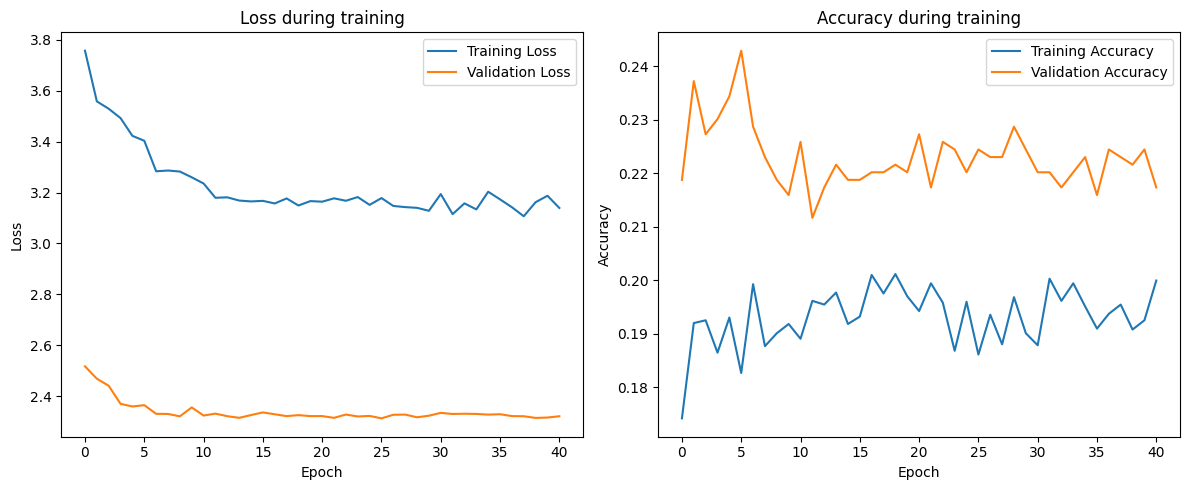

In [25]:
# Loss and accuracy visualization during the training model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

23/23 [==============================] - 8s 365ms/step


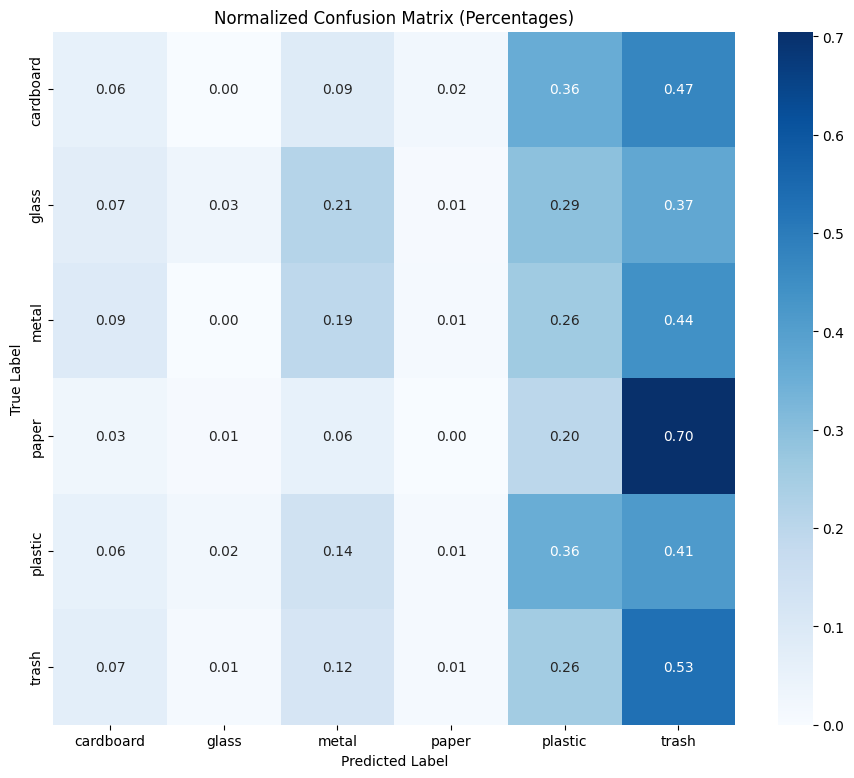

In [27]:
# Make predictions on the test set using the best model (if you haven't already)
predictions = model.predict(X_test_preprocessed)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test_encoded, axis=1)

# Calculate the confusion matrix (non-normalized)
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix to show percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Visualize the normalized confusion matrix
plt.figure(figsize=(11, 9))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix (Percentages)')
plt.show()